MCMC

In order to run this notebook yourself, you will need the dataset located here:
- Go to https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100099

- Download the file `GSE100099_RNASeqGEO.tsv.gz`


In [1]:
import tensorflow as tf

from timeit import default_timer as timer
from IPython.display import display
import matplotlib.pyplot as plt

from lafomo.datasets import DataHolder, HafnerData
from lafomo.utilities.tf import discretise, logistic, LogisticNormal, inverse_positivity
from lafomo.plot import mcmc_plotters
from lafomo.mcmc.models import TranscriptionRegulationLFM
from lafomo.configuration import MCMCConfiguration

import numpy as np
import pandas as pd


f64 = np.float64
np.set_printoptions(threshold=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.10f}".format(x)})

In [2]:
target_genes = [
    'KAZN','PMAIP1','PRKAB1','CSNK1G1','E2F7','SLC30A1',
    'PTP4A1','RAP2B','SUSD6','UBR5-AS1','RNF19B','AEN','ZNF79','XPC',
    'FAM212B','SESN2','DCP1B','MDM2','GADD45A','SESN1','CDKN1A','BTG2'
]
known_target_genes = [
    'CDKN1A', #p21
    'SESN1', #hPA26
    'DDB2',
    'TNFRSF10B',
    'BIK',
]
dataset = HafnerData(replicate=0, extra_targets=False, data_dir='../../../data')
num_replicates = 1
num_genes = len(dataset.gene_names)
num_tfs = 1
num_times = dataset[0][0].shape[0]

t_observed = np.arange(0, 13)
t_predict = tf.linspace(0, 13, 80)

m_observed = np.stack([
    dataset[i][1] for i in range(num_genes*num_replicates)
])
m_observed = m_observed.reshape(num_replicates, num_genes, num_times)
m_observed = np.float64(m_observed)
print(type(m_observed))
f_observed = dataset.tfs

replicate = 0

τ, common_indices = discretise(t_observed, num_disc=13)
data = DataHolder((m_observed, f_observed), None, (t_observed, τ, tf.constant(common_indices)))

print(f_observed.shape, m_observed.shape)

<class 'numpy.ndarray'>
(2, 1, 13) (1, 22, 13)


In [3]:
opt = MCMCConfiguration(
    preprocessing_variance=False,
    latent_data_present=False,
    delays=False,
    weights=False,
    kinetic_exponential=False,
    initial_step_sizes={'nuts': 0.000006, 'latents': 10},
    kernel='rbf'
)

model = TranscriptionRegulationLFM(data, opt)


In [4]:
start = timer()
model.sample(T=2000, burn_in=0)
end = timer()
print(f'Time taken: {(end - start):.04f}s')

----- Sampling Begins -----
Preparing HMCSampler ['basal', 'decay', 'sensitivity', 'initial', 'protein_decay']
Preparing LatentGPSampler ['latent']
Preparing GibbsSampler ['σ2_f']
Preparing GibbsSampler ['σ2_m']
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Progress: 	 100%	| "==================="""| 
----- Finished -----
Time taken: 28.2938s


In [5]:
do_save = False
do_load = False
if do_save:
    model.save('human')
if do_load:
    # Initialise from saved model:
    model = TranscriptionRegulationLFM.load('human', [data, opt])
    is_accepted = model.is_accepted

In [6]:
is_accepted = model.sampler.is_accepted

pcs = list()
for i, subsampler in enumerate(model.subsamplers):
    pcs.append(tf.reduce_mean(tf.cast(is_accepted[i], dtype=tf.float32)).numpy())

display(pd.DataFrame([[f'{100*pc:.02f}%' for pc in pcs]], columns=list(model.subsamplers)))

plot_opt = mcmc_plotters.PlotOptions(
    num_plot_genes=10, num_plot_tfs=10,
    gene_names=np.array(dataset.gene_names), tf_names=np.array(['p53']),
    true_label='Hafner et al.', for_report=False, ylabel='normalised FPKM',
    kernel_names=model.kernel_selector.names(), num_hpd=200, tf_present=False
)
plotter = mcmc_plotters.Plotter(data, plot_opt)

# Calculate gene samples
results = model.results(burnin=300)
print(results['basal'].shape)


,"HMCSampler ['basal', 'decay', 'sensitivity', 'initial', 'protein_decay']",LatentGPSampler ['latent'],GibbsSampler ['σ2_f'],GibbsSampler ['σ2_m']
0,43.05%,2.65%,100.00%,100.00%


(300, 22, 1)


tf.Tensor(
[[1.4224742744]
 [1.1476091422]
 [1.3210484797]
 [1.5196166648]
 [1.4572523680]
 [1.3085409486]
 [0.9595183101]
 [1.0623496137]
 [1.5579451644]
 [1.4260603754]
 [1.3968099414]
 [1.1618437379]
 [1.2903149791]
 [1.4038266036]
 [1.5116862156]
 [1.0644957738]
 [1.6601600178]
 [1.0283721659]
 [1.0682975522]
 [1.0237053279]
 [0.4247928967]
 [1.0050527617]], shape=(22, 1), dtype=float64)
(1000, 22, 1)


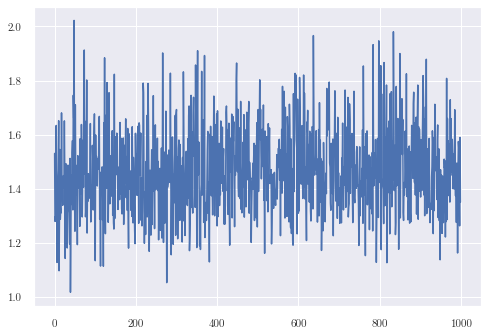

In [7]:
print(results['decay'][-1])# delay = results.delay[-i] if self.options.delays else None
results = model.results(1000)
noise = results['σ2_m']
print(noise.shape)
plt.plot(noise[:, 0])

In [8]:
print(results['basal'][-1])

tf.Tensor(
[[1.2736846675]
 [1.1612027926]
 [1.3405749439]
 [1.5363976087]
 [1.2155577760]
 [1.3900892509]
 [1.2887085097]
 [1.3055802189]
 [1.7847837284]
 [1.5887237032]
 [1.3047584823]
 [1.7557271803]
 [1.6620260188]
 [1.4295836518]
 [1.1879562864]
 [1.3399407655]
 [1.3349149028]
 [1.3090938891]
 [1.2039111988]
 [1.7332063237]
 [10.3559737338]
 [1.8533600292]], shape=(22, 1), dtype=float64)


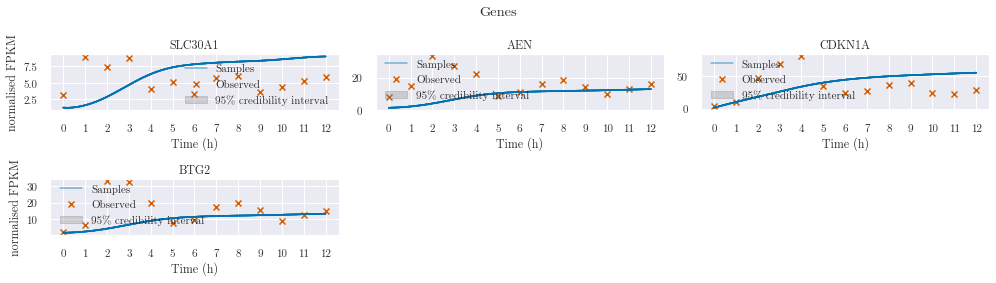

In [9]:
m_preds = model.sample_latents(results, 20)

plotter.plot_outputs(m_preds, replicate=0, height_mul=2, indices=[5, 11, 20, 21])
# plt.legend(bbox_to_anchor=(0, -1));

(1000, 22, 3)


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\arviz\stats\stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


(array([[0.1227541663]]), array([[[0.0001029408, 0.0000655517]]]))

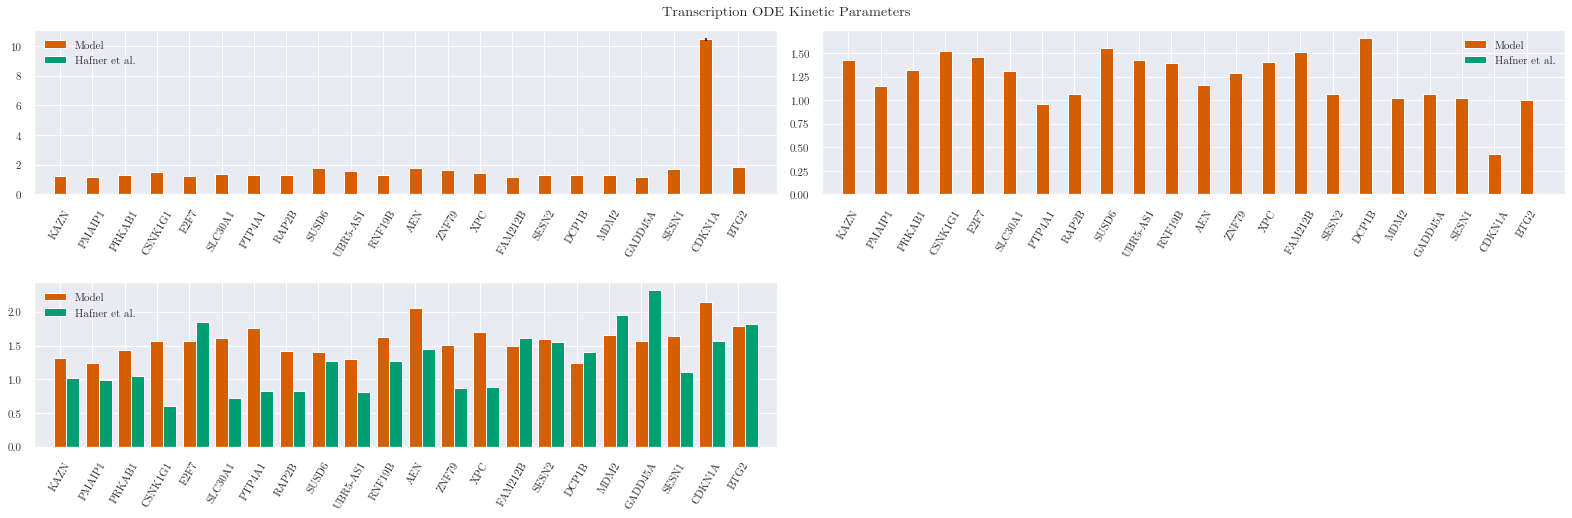

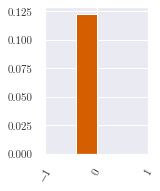

In [10]:
kinetic_params = ['basal', 'decay', 'sensitivity']
kinetics = np.stack([results[k] for k in kinetic_params]).transpose((1, 2, 0, 3)).squeeze(-1)
mean_kinetics = np.mean(kinetics[-50:], axis=0)

dec = np.array([0.284200056, 0.399638904, 0.062061123]) #todo incorrect order
sens = np.array([4.002484948, 32.89511304, 4.297906129])
sens = np.array([
    0.232461671,0.429175332,1.913169606,0.569821512,2.139812962,0.340465324,
    4.203117214,0.635328943,0.920901229,0.263968666,1.360004451,4.816673998,
    0.294392325,2.281036308,0.86918333,2.025737447,1.225920534,11.39455009,
    4.229758095,4.002484948,32.89511304,7.836815916])
dec = np.array([
    0.260354271,0.253728801,0.268641114,0.153037374,0.472215028,0.185626363,
    0.210251586,0.211915623,0.324826082,0.207834775,0.322725728,0.370265667,
    0.221598164,0.226897275,0.409710437,0.398004589,0.357308033,0.498836353,
    0.592101838,0.284200056,0.399638904,0.463468107])

true_k = np.zeros((num_genes, 4))

dec = dec/np.mean(dec) * np.mean(mean_kinetics[:, 1])
true_k[:,2] = 1.02*dec

sens = sens/np.mean(sens)* np.mean(mean_kinetics[:, 2])
true_k[:,3] = sens
print(kinetics.shape)
transform = np.exp
transform = None
plotter.plot_kinetics(results, kinetic_params,
                      xlabels=np.array(dataset.gene_names),
                      title='Transcription ODE Kinetic Parameters',
                      true_k=true_k, transform=transform)

plotter.plot_kinetics(results, ['protein_decay'], transform=transform)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


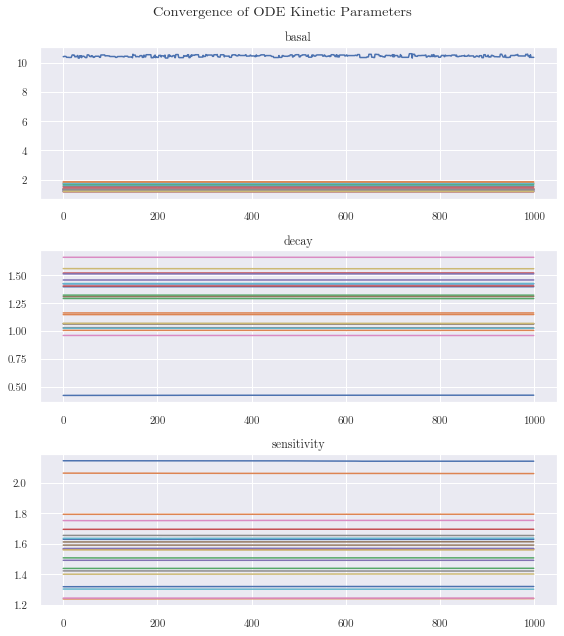

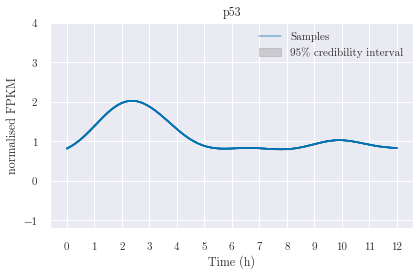

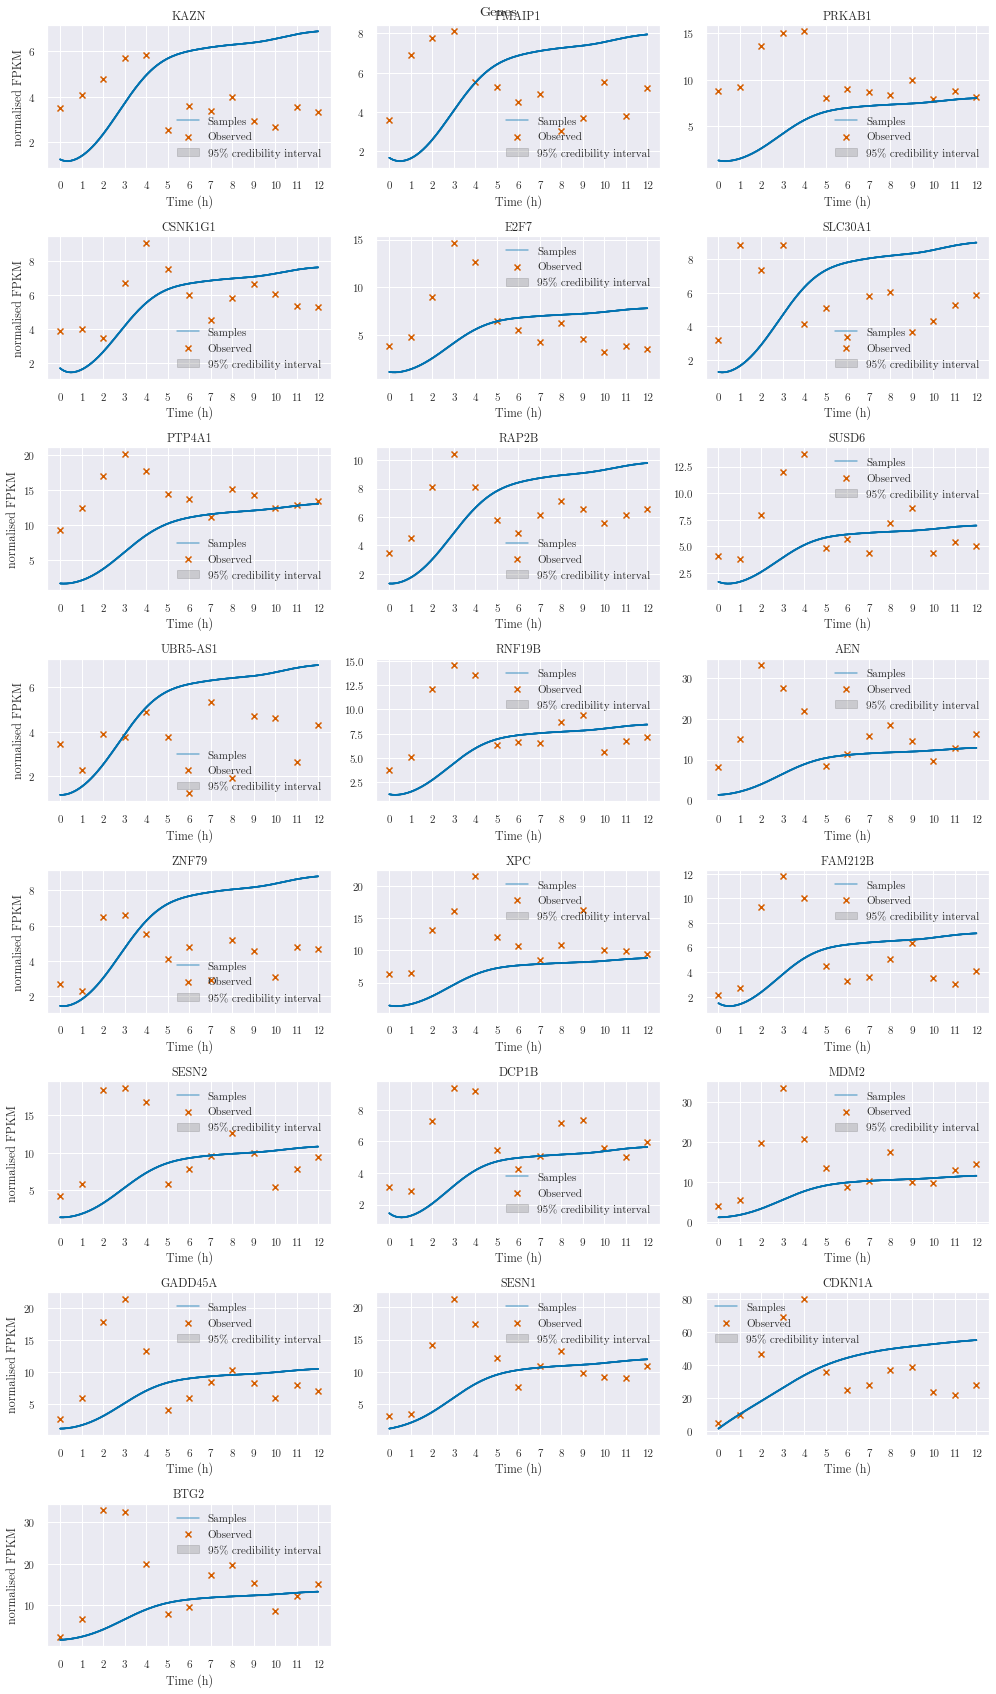

In [11]:
plotter.plot_convergence(results, kinetic_params,
                         title='Convergence of ODE Kinetic Parameters',
                         transform=transform)

f_samples = inverse_positivity(results['latent'][0])
plotter.plot_latents(f_samples, replicate=replicate)
plotter.plot_outputs(m_preds, replicate=replicate)

In [11]:
print(f_samples.shape)

(1000, 2, 1, 169)


In [12]:
# from IPython.display import HTML
#
# HTML(plotter.anim_latent(f_samples))

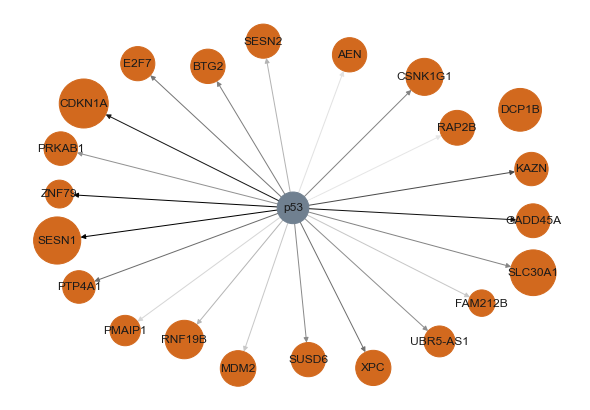

In [13]:
plt.figure()
plotter.plot_grn(results, kinetic_params)


In [14]:
results['sensitivity'] *= 2
print(results['sensitivity'][-1])

tf.Tensor(
[[3.7869732760]
 [1.5948173528]
 [2.5829769128]
 [2.9097265254]
 [3.4280450937]
 [3.1466930544]
 [3.2407840668]
 [1.3438523987]
 [2.6966521072]
 [2.5841391496]
 [2.0323563896]
 [1.5513953097]
 [4.9351893593]
 [3.2298924325]
 [1.8849046920]
 [2.4678941589]
 [0.9910152587]
 [1.9445042607]
 [4.4556294380]
 [4.9614972413]
 [4.4979334447]
 [3.0348057021]], shape=(22, 1), dtype=float64)


In [15]:
# plt.figure()
# kp = np.array(results.kernel_params).swapaxes(0,1)
# kp_latest = np.mean(kp[-50:], axis=0)
# self.plot_bar_hpd(kp, kp_latest, self.opt.kernel_names)



In [16]:
# Plot proteins
p_samples = model.sample_proteins(results, 20)[:,0]
print(p_samples.shape)
plotter.plot_samples(p_samples, [''], 4, color='orangered')
plt.xlim(0, 10)
plt.ylim(-0.05, 2.5)
print(8.51/4.72)
plt.figure(figsize=(4*1.80297, 4))
p = p_samples[-1]
y = [1.5, 4.8, 13.7, 5, 2, 1.4, 3.2, 4, 1.4, 1.5]
# y = y/np.mean(y)*np.mean(p) * 1.75-0.16
# y = scaler.fit_transform(np.expand_dims(y, 0))
plt.plot(t[1:11], y)
plt.ylim(0, 15)
plt.ylabel('p53 fold change')
plt.xlabel('Time (h)')
plt.xticks(np.arange(1, 11))
plt.yticks(np.arange(0, 16, 5))

plt.tight_layout()

KeyError: 'delay'

In [ ]:
from tensorflow_probability import distributions as tfd
from lafomo.utilities.tf import jitter_cholesky, inverse_positivity

kparams = model.kernel_selector.initial_params()
print(kparams[0])

step_size = 1 * tf.ones(169, dtype='float64')
latent_sampler = model.subsamplers[1]

current_state = 0.3* tf.ones((2, 1, 169), dtype='float64')

new_state = tf.identity(current_state)
new_params = []
S = tf.linalg.diag(step_size)
invS = tf.expand_dims(tf.linalg.inv(S), 0)

# MH
m, K = latent_sampler.fbar_prior_params(kparams[0], kparams[1])
# Propose new params
v = model.kernel_selector.proposal(0, kparams[0]).sample()
l2 = model.kernel_selector.proposal(1, kparams[1]).sample()
m_, K_ = latent_sampler.fbar_prior_params(v, l2)
print(v)
# Draw surrogate data
fbar = new_state
g = tfd.MultivariateNormalDiag(fbar, step_size).sample()
# assume only one TF:
g = tf.transpose(g, (0, 2, 1))
fbar = tf.transpose(fbar, (0, 2, 1))
# g is quite a large random sample centred around fbar with
# noise proportional to step_size
# plt.plot(g[0][0])

# Compute K_i(K_i + S)^-1
R = S - tf.matmul(S, tf.matmul(tf.linalg.inv(S+K), S))
L_R = jitter_cholesky(R)
R_ = S - tf.matmul(S, tf.matmul(tf.linalg.inv(S+K_), S))
L_R_ = jitter_cholesky(R_)

print(R.shape, invS.shape, g.shape)
m_g = tf.matmul(tf.matmul(R, invS), g)
m_g_ = tf.matmul(tf.matmul(R_, invS), g)

plt.plot(m_g[0,:,0])
plt.plot(m_g_[0,:,0])

nu = tf.matmul(tf.linalg.inv(L_R), (fbar-m_g))
print(fbar.shape, m_g.shape, (fbar-m_g).shape)
# Compute chol(K-K(K+S)^-1 K)
# L = jitter_cholesky(K-tf.matmul(Ksuminv, K))
# c_mu = tf.linalg.matvec(Ksuminv, g)
# # Compute nu = L^-1 (f-mu)
# invL = tf.linalg.inv(L)
# nu = tf.linalg.matvec(invL, fbar-c_mu)
#
# Ksuminv = tf.matmul(K_, tf.linalg.inv(K_+S))
# L = jitter_cholesky(K_-tf.matmul(K_, Ksuminv))
# c_mu = tf.linalg.matvec(Ksuminv, g)
print(L_R_.shape, nu.shape, tf.linalg.matmul(L_R_, nu).shape)
fstar = tf.linalg.matmul(L_R_, nu) + m_g_
print(fstar.shape)
fstar = tf.transpose(fstar, (0, 2, 1))
plt.figure()
plt.plot(inverse_positivity(fstar)[0][0])
print('final shape', fstar.shape)